# ***MNIST Example***

In [ ]:
# please make sure that you have the following libraries, otherwise you shall install them.
# just uncomment the pip command down below and run this cell
# %pip install numpy matplotlib idx2numpy os plotly

In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from os import listdir, mkdir
from os.path import isfile, join, isdir
import plotly.express as px
import plotly.graph_objects as go

In [2]:
X_train = idx2numpy.convert_from_file(
    './dataset/train-images-idx3-ubyte').reshape(60000, 784)
X_test = idx2numpy.convert_from_file(
    './dataset/t10k-images-idx3-ubyte').reshape(10000, 784)
y_train = idx2numpy.convert_from_file('./dataset/train-labels-idx1-ubyte')
y_test = idx2numpy.convert_from_file('./dataset/t10k-labels-idx1-ubyte')

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
m, n = X_train.shape

fig, axes = plt.subplots(5, 5, figsize=(5, 5))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X_train[random_index].reshape((28, 28))

    # Display the image
    ax.imshow(X_random_reshaped, cmap='PuBuGn')

    # Display the label above the image
    ax.set_title(y_train[random_index])
    ax.set_axis_off()

In [3]:
def relu(Z): return np.maximum(0, Z)

def sigmoid(Z): return 1.0 / (1.0 + np.exp(-Z))

def softmax(Z):
    exponentias = np.exp(Z - np.max(Z, axis=1).reshape(-1, 1))
    return exponentias / np.sum(exponentias, axis=1).reshape(-1, 1)

def relu_derevative(Z): return Z > 0

def sigmoid_derevative(sig): return sig * (1.0 - sig)

def softmax_grad(soft):
    s = soft.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


In [4]:
class Layer:
    def __init__(self, neurons, activation, activation_drev):
        self.neurons = neurons
        self.activation = activation
        self.activation_drev = activation_drev

In [7]:
class NeuralNetwork:
    def __init__(self, X_train, X_test, y_train, y_test, **layers):
        self.X_train_norm = self.data_normalize(X_train)
        self.X_test_norm = self.data_normalize(X_test)
        self.m = self.X_train_norm.shape[0]
        self.y_train = np.array(
            [self.convert2_OneHotEncodeing(y) for y in y_train])
        self.y_test = np.array(
            [self.convert2_OneHotEncodeing(y) for y in y_test])
        self.layers = list(layers.items())
        self.Weights = []
        self.Biases = []
        self.j_train = np.array([])
        self.j_test = np.array([])
        for index, layer in enumerate(self.layers):
            if index == 0:
                self.Weights.append(np.random.rand(
                    self.X_train_norm.shape[1], layer[1].neurons) - 0.5)
            else:
                self.Weights.append(np.random.rand(
                    self.layers[index - 1][1].neurons, layer[1].neurons) - 0.5)
            self.Biases.append(np.random.rand(1, layer[1].neurons) - 0.5)

    def convert2_OneHotEncodeing(self, index):
        e = np.zeros((10))
        e[index] = 1.0
        return e

    def data_normalize(self, X):
        X_norm = np.zeros_like(X)
        for index in range(X.shape[1]):
            avg = np.average(X[:, index])
            std = np.std(X[:, index])
            if std != 0:
                X_norm[:, index] = (X[:, index] - avg) / std
            else:
                X_norm[:, index] = X[:, index]
        return np.array(X_norm)

    def parameters(self):
        n_weights = 0
        for W, B in zip(self.Weights, self.Biases):
            n_weights += np.size(W) + np.size(B)
        print('total parameters in your model', n_weights)
        return n_weights

    def cross_entropy(self, y):
        y_pred_clipped = np.clip(self.y_predict, 1e-8, 1 - 1e-8)
        return -1 * np.mean(y * np.log(y_pred_clipped))

    def cross_entropy_grad(self, y): return self.y_predict - y

    def dense(self, A_in, W, B, activation):
        Z = np.matmul(A_in, W) + B
        self.Z.append(Z)
        A_out = activation(Z)
        return A_out

    def forwardPropagation(self, X):
        self.A = [X]
        self.Z = []
        for index, layer in enumerate(self.layers):
            self.A.append(self.dense(
                self.A[index], self.Weights[index], self.Biases[index], layer[1].activation))
        self.y_predict = self.A[-1]

    def backwardPropagation(self, learning_rate):
        delta = self.cross_entropy_grad(self.y_train)
        dw = np.matmul(self.A[-2].T, delta) / self.m
        db = np.mean(delta, axis=0).reshape(1, -1)
        for index in reversed(np.arange(len(self.layers))): # 2 1 0
            self.Weights[index] -= learning_rate * dw
            self.Biases[index] -= learning_rate * db
            if index == 0: break
            delta = np.matmul(
                delta, self.Weights[index].T) * self.layers[index - 1][1].activation_drev(self.Z[index - 1])
            dw = np.matmul(self.A[index - 1].T, delta) / self.m
            db = np.mean(delta, axis=0).reshape(1, -1)

    def fit(self, iterations=10000, learning_rate=0.01):
        for i in range(iterations):
            self.forwardPropagation(X=self.X_test_norm)
            self.j_test = np.append(self.j_test, self.cross_entropy(self.y_test))

            self.forwardPropagation(X=self.X_train_norm)
            self.j_train = np.append(self.j_train, self.cross_entropy(self.y_train))

            self.backwardPropagation(learning_rate)
        self.testModel()

    def get_accuracy(self, y):
        return np.sum(
            np.argmax(self.y_predict, axis=1) == np.argmax(y, axis=1)
            ) / self.y_predict.shape[0]

    def testModel(self):
        x = np.arange(len(self.j_train))
        px.line(x=x, y=self.j_train).update_layout( 
            title="Cost function of training examples", 
            xaxis_title='iterations', 
            yaxis_title='J_train', 
            template='plotly_dark').show()

        px.line(x=x, y=self.j_test).update_layout( 
            title="Cost function of testing examples", 
            xaxis_title='iterations', 
            yaxis_title='J_test', 
            template='plotly_dark').show()

    def save_model(self, index):
        if not isdir(f'./models/model_{index}/'):
            mkdir(f'./models/model_{index}/')
        # save parameters
        for i, (w, b) in enumerate(zip(self.Weights, self.Biases)):
            np.savetxt(f'./models/model_{index}/W_{i}.txt', w, fmt='%1.9f')
            np.savetxt(f'./models/model_{index}/B_{i}.txt', b, fmt='%1.9f')
        
        np.savetxt(f'./models/model_{index}/J-train.txt', self.j_train, fmt='%1.9f')
        np.savetxt(f'./models/model_{index}/J-train.txt', self.j_test, fmt='%1.9f')
        
        # add model's summary 
        with open(f'./models/model_{index}/model_summary.md', "w") as f:
            f.write(f'# ***Model {index}***\n\n')
            f.write(f'Here is the summary of a trained model for the MNIST dataset.\n\n')
            f.write(f'## **1. Model Design**\n')
            f.write(f'## This model is consisted of *{len(self.layers)}* layers:\n\n')

            for i, layer in enumerate(self.layers):
                f.write(f'Layer {i + 1}: \n')
                f.write(f'Layer {i + 1} is consisted of *{self.Weights[i].shape[1]}* neurons.\n\n')
                f.write(f'so the shape of its *Weights and Biases* are: \n\n ')
                f.write(f'- Weights = {self.Weights[i].shape}\n\n')
                f.write(f'- Biases = {self.Biases[i].shape}\n\n')

            f.write(f'The total parameters of this model = {self.parameters()}\n')
            
            f.write(f'## **2. Model\'s Accuracy**\n')
            self.forwardPropagation(self.X_train_norm)
            train_loss = self.cross_entropy(self.y_train)
            f.write(f'- ### Model\'s accuracy on the training examples: \
                {self.get_accuracy(self.y_train) * 100}\n\n')
            self.forwardPropagation(self.X_test_norm)
            test_loss = self.cross_entropy(self.y_test)
            f.write(f'- ### Model\'s accuracy on the testing examples: \
                {self.get_accuracy(self.y_test) * 100}\n\n')
            
            f.write(f'## **3. Model\'s Losses**\n')
            f.write(f'- ### Model\'s losses on the training examples: \
                {train_loss}\n\n')
            f.write(f'- ### Model\'s losses on the testing examples: \
                {test_loss}\n')

    def load_model(self, index):
        path = f'./models/model_{index}/'
        files = [f for f in listdir(path) if isfile(join(path, f))]
        files.remove('model_summary.md')
        self.Biases, self.Weights = [], []

        for i in range((len(files) / 2).__ceil__()):
            self.Biases.append(np.loadtxt(f'./models/model_{index}/B_{i}.txt').reshape(1, -1))
            self.Weights.append(np.loadtxt(f'./models/model_{index}/W_{i}.txt'))
        
        self.j_train = np.loadtxt(f'./models/model_{index}/J-train.txt')
        self.j_test = np.loadtxt(f'./models/model_{index}/J-test.txt')

        for w, b in zip(self.Weights, self.Biases):
            print(f'Weights: {w.shape}')
            print(f'Biases: {b.shape}')

In [11]:
model = NeuralNetwork(
    X_train=X_train,
    X_test=X_test,
    y_test=y_test,
    y_train=y_train,
    layer1=Layer(neurons=25, activation=relu, activation_drev=relu_derevative),
    layer2=Layer(neurons=15, activation=relu, activation_drev=relu_derevative),
    layer3=Layer(neurons=10, activation=softmax, activation_drev=softmax_grad)
)
model.load_model(1)

Weights: (784, 25)
Biases: (1, 25)
Weights: (25, 15)
Biases: (1, 15)
Weights: (15, 10)
Biases: (1, 10)


In [ ]:
model.fit(iterations=50, learning_rate=0.01)

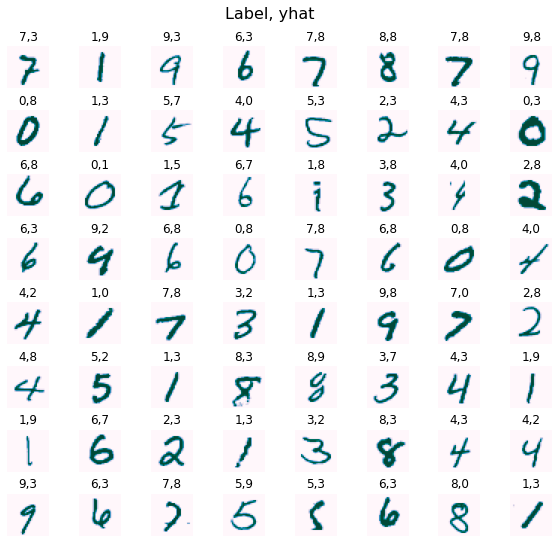

In [13]:
model.forwardPropagation(model.X_train_norm)
m, n = X_train.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X_train[random_index].reshape((28,28))
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='PuBuGn')
    
    # Predict using the Neural Network
    yhat = np.argmax(model.y_predict[random_index])

    # Display the label above the image
    ax.set_title(f"{y_train[random_index]},{yhat}")
    ax.set_axis_off()

fig.suptitle("Label, yhat", fontsize=16)
plt.show()

In [14]:
model.forwardPropagation(model.X_train_norm)

print(f'training set prediction accuracy {model.get_accuracy(y=model.y_train)}')

model.forwardPropagation(model.X_test_norm)

print(f'testing set prediction accuracy {model.get_accuracy(y=model.y_test)}')


training set prediction accuracy 0.031266666666666665
testing set prediction accuracy 0.0353


In [ ]:
model.save_model(2)